In [1]:
import numpy as np
import pandas as pd
print pd.__version__

0.19.1


In [2]:
data_dir = "data/pdaid/"
!ls $data_dir

bacterial.csv         parasitic.csv         viral.csv
fungal.csv            protein_ids.txt
merged_iedb_swiss.csv proteins.fasta


In [3]:
disease_col = "disease"
bacterial = pd.DataFrame.from_csv(data_dir + "bacterial.csv")
bacterial[disease_col] = "bacterial"
fungal = pd.DataFrame.from_csv(data_dir + "fungal.csv")
fungal[disease_col] = "fungal"
parasitic = pd.DataFrame.from_csv(data_dir + "parasitic.csv")
parasitic[disease_col] = "parasitic"
viral = pd.DataFrame.from_csv(data_dir + "viral.csv")
viral[disease_col] = "viral"
print "Input -- Bacterial: %d, Fungal: %d, Parasitic: %d, Viral: %d" % \
    (bacterial.shape[0], fungal.shape[0], parasitic.shape[0], viral.shape[0])

all_samples = bacterial.append(fungal, ignore_index=True)\
    .append(parasitic, ignore_index=True)\
    .append(viral, ignore_index= True)
all_samples.columns = [
        'type', 'epitope_sequence', 'start', 'end', 'chebi', 'syn', 'protein',
        'protein_id', 'organism', 'oid', 'comments', 'disease'
    ]
# Remove entries with '+' notation (note: looking into this, e.g. "PLNISLGDVVLY + DEAM(N3)")
all_samples = all_samples[all_samples.epitope_sequence.str.find('+') == -1]
print "All filtered samples: %d" % (all_samples.shape[0])

Input -- Bacterial: 3475, Fungal: 39, Parasitic: 3444, Viral: 8066
All filtered samples: 14875


In [4]:
all_samples = all_samples[["epitope_sequence", "disease"]]

In [5]:
# Remove epitopes less than 9 AAs long
all_samples = all_samples[all_samples.epitope_sequence.str.len() >= 9]

dup_mask = all_samples.duplicated(subset=["epitope_sequence"], keep=False)
dups = all_samples[dup_mask].sort_values(by=["epitope_sequence"])
nondups = all_samples[dup_mask == False]
print "There are %d (of %d) duplicate rows" % (dups.shape[0], nondups.shape[0])

There are 62 (of 13508) duplicate rows


In [6]:
import numpy as np
import pandas as pd
from math import log

seq_len = 18

amino_acids = {"A": "Alanine",
            "B": "Aspartic acid or Asparagine",
            "C": "Cysteine",
            "D": "Aspartic Acid",
            "E": "Glutamic Acid",
            "F": "Phenylalanine",
            "G": "Glycine",
            "H": "Histidine",
            "I": "Isoleucine",
            "K": "Lysine",
            "L": "Leucine",
            "M": "Methionine",
            "N": "Asparagine",
            "P": "Proline",
            "Q": "Glutamine",
            "R": "Arginine",
            "S": "Serine",
            "T": "Threonine",
            "U": "Selenocysteine",
            "V": "Valine",
            "W": "Tryptophan",
            "Y": "Tyrosine",
            "Z": "Glutamic acid or Glutamine"}

def alphabet_dict():
    d = {}
    for letter in amino_acids.keys():
        d[letter] = 0
    return d

def init_counters():
    return [alphabet_dict() for i in range(seq_len)]

counters = {"bacterial": init_counters(),
            "viral": init_counters(),
            "parasitic": init_counters(),
            "fungal": init_counters(),
            "total": init_counters()}
for (rowid, seq, disease) in nondups.itertuples():
    foo = seq[::-1]
    bar = foo[:seq_len]
    for (i, aa) in enumerate(bar):
        counters[disease][i][aa.upper()] += 1

for i in range(seq_len):
    for aa in amino_acids.keys():
        counters["total"][i][aa] += (counters["bacterial"][i][aa] + counters["viral"][i][aa]\
                          + counters["fungal"][i][aa] + counters["parasitic"][i][aa])
    
def prob(disease, pos, aa):
    counter = counters[disease][pos]
    total = 0
    for count in counter.values():
        total += count
    if counter[aa] == 0:
        return 0
    else:
        return float(counter[aa])/total
    
def safe_log(x):
    if x <= 0:
        return float("-inf")
    return log(x, 2.0)

def generate_kl_heatmap(disease):
    result = [alphabet_dict() for i in range(seq_len)]
    for i in range(seq_len):
        for letter in amino_acids.keys():
            result[i][letter] = prob(disease, i, letter) * safe_log( prob(disease, i, letter) / max(0.00000001, prob("total", i, letter)))

    r = pd.DataFrame(result).transpose()
    vmin = r.min().min()
    vmax = r.max().max()
    center = (vmax - vmin)/2

    import seaborn as sns
    sns.set()
    ax = sns.heatmap(r, linewidths=.5,
            yticklabels=["%s (%s)" % (amino_acids[code], code) for code in r.index],
            xticklabels=["%d" %(i) for i in range(seq_len)], 
            vmin=vmin, vmax=vmax, center=center, cmap="YlGnBu", alpha=0.8)
    ax.set_title('%s Kullback-Leibler Information, $I(i) = \sum_{L=0}^{N}p_{i}^{L}\log_2(p_{i}^{L}/q_{i}^{L})$' % (disease))

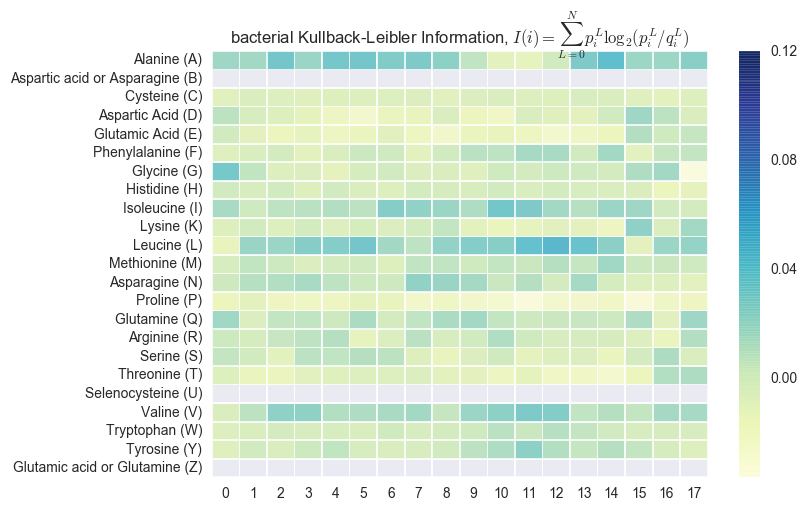

In [7]:
%matplotlib inline
generate_kl_heatmap("bacterial")

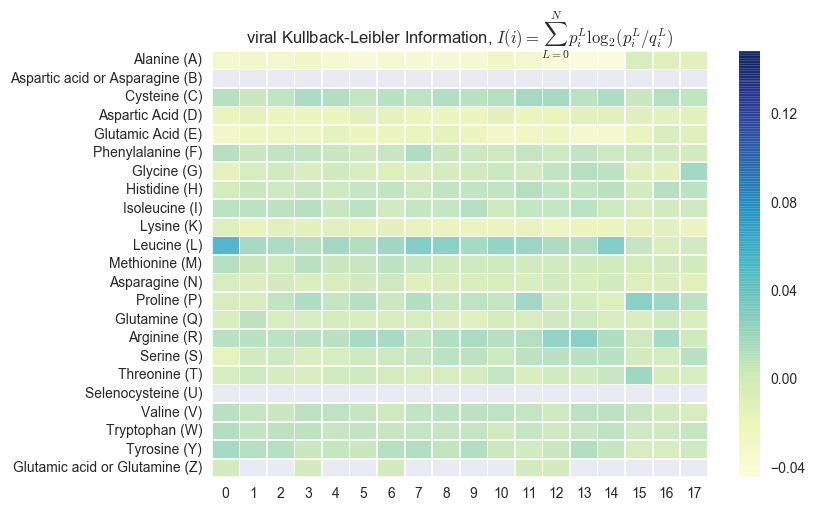

In [8]:
%matplotlib inline
generate_kl_heatmap("viral")

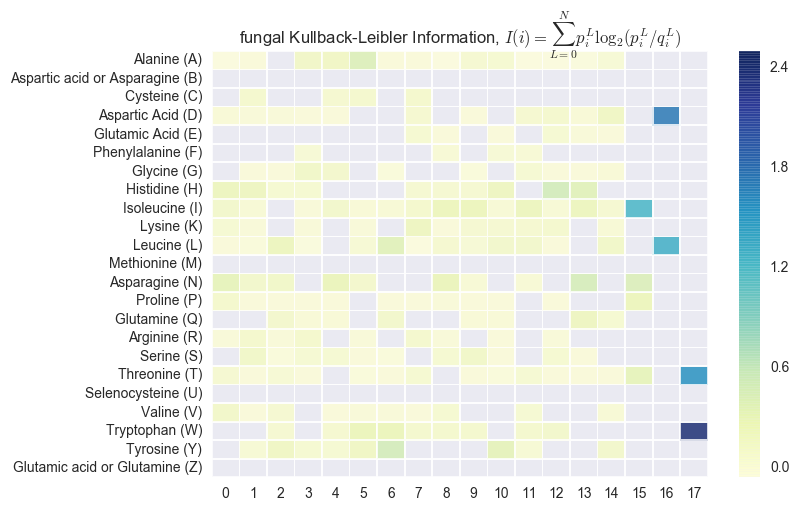

In [9]:
%matplotlib inline
generate_kl_heatmap("fungal")

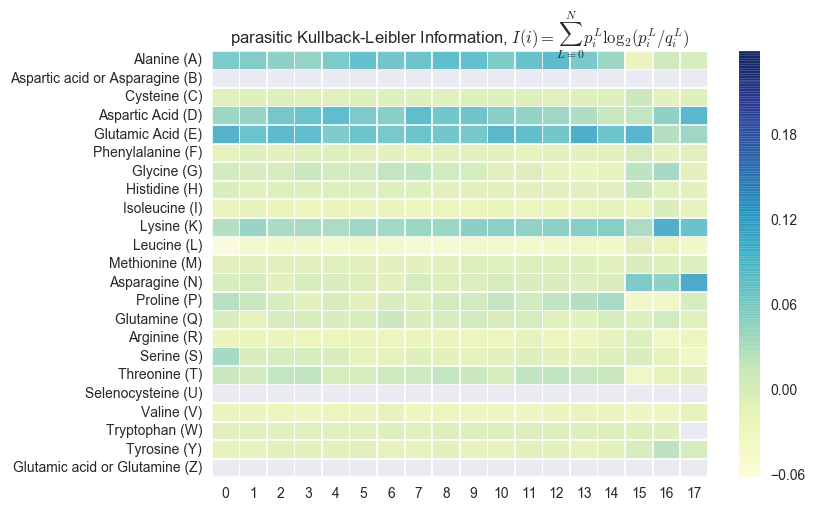

In [10]:
%matplotlib inline
generate_kl_heatmap("parasitic")